In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import sys
sys.path.append('./src/')
sys.path.append('./src/models/')

from cond_CFM import CNF, FlowMatchingLoss

sys.path.append('../MCMC_by_backprob/src/')
from MCMC_Adam import MCMC_by_bp

import numpy as np
import os
from tqdm import tqdm

from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout, Flipout_Dropout, LinearDropout

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle

In [2]:
from src.utils import *
from src.dataloader import *
from src.plot_util import *

In [3]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
#######################
### Define the data ###
#######################

from dataloader import *
from torch.utils.data import Dataset

class cond_dataset(Dataset):
    def __init__(self, x, c):
        super(Dataset, self).__init__()
        self.x = x
        self.c = c

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.c[index]

add_str_save = ''
data_dim = 2 #5
save_as_try = 0 #0
n_samples = 1_000_000

data_path = './data/' 

donut_args = {'u_mean':0, 'u_sigma':1, 'r_mean': 4.0, 'r_sigma': 1, 'm_cut': 'inf', 'gamma_scale': 1.0}

In [7]:
########################
### Define the Model ###
########################
p = 0
n_nodes = 32
n_layers = 3

model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers)
        
model.to(device)

for layer in model.modules():
    if isinstance(layer, LinearFlipout):
        layer._dnn_to_bnn_flag = True
        layer.auto_sample = False 

print(f"initiated model with {sum(p.numel() for p in model.parameters())} parameters")

initiated model with 2498 parameters


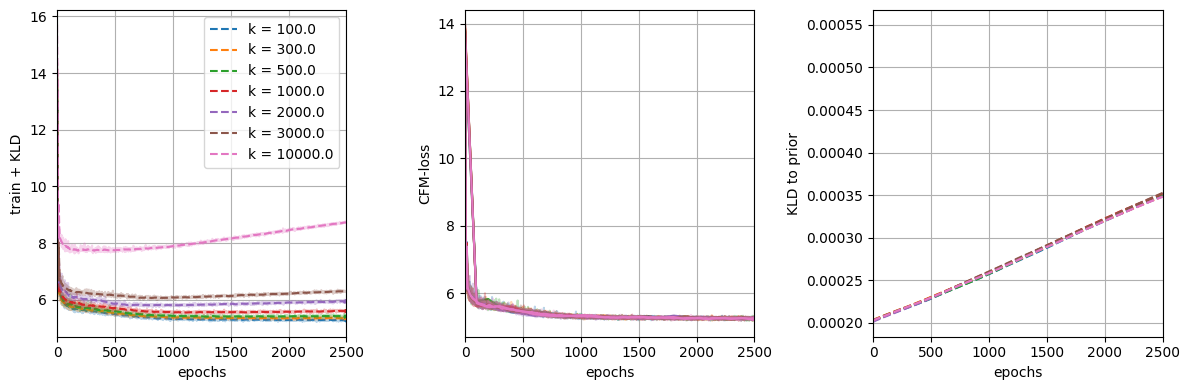

In [21]:
c_factors = [100.,300.,500.,1000.,2000.,3000.,10000.]
save_as_try = [0,0,0,0,0,1,0]
ep_lowest = [2499, 2499, ]
eps = [2499,2499,2499,2499,2499,9999,4999] 

fig, ax = plt.subplots(1,3, figsize = (12,4))

for i_c, c_factor in enumerate(c_factors):
    ep = eps[i_c]
    save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
    save_dir = save_dir + f'/donut_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'+f'{save_as_try[i_c]}/'

    with open(save_dir + f'loss_hist_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)
    with open(save_dir + f'loss_hist_KLD_{ep}.npy', 'rb') as f:
        loss_hist_KLD =  np.load(f)
    with open(save_dir + f'loss_hist_test_{ep}.npy', 'rb') as f:
        loss_hist_test =  np.load(f)
    with open(save_dir + f'loss_hist_test_ep_{ep}.npy', 'rb') as f:
        loss_hist_test_ep =  np.load(f)

    ax[0].plot(smooth(loss_hist + c_factor*loss_hist_KLD,1), color = f'C{i_c}', linestyle = '--',alpha = 0.3)
    ax[0].plot(smooth(loss_hist + c_factor*loss_hist_KLD,31), color = f'C{i_c}', linestyle = '--', label = f'k = {c_factor}')

    ax[1].plot(smooth(loss_hist,1), color = f'C{i_c}', alpha = 0.3)
    ax[1].plot(smooth(loss_hist,31), color = f'C{i_c}', label = 'train')
    ax[1].plot(loss_hist_test_ep, loss_hist_test, color = f'C{i_c}', label = 'test')

    ax[2].plot(smooth(loss_hist_KLD,1), color = f'C{i_c}', linestyle = '--',alpha = 0.3)
    ax[2].plot(smooth(loss_hist_KLD,31), color = f'C{i_c}', linestyle = '--', label = f'k = {c_factor}')

ax[0].set_ylabel('train + KLD')
ax[1].set_ylabel('CFM-loss')
ax[2].set_ylabel('KLD to prior')
for a in ax:
    a.set_xlabel('epochs')
    a.set_xlim(0,2500)
    a.grid()
ax[0].legend()
plt.tight_layout()
plt.show()    